In [19]:
# Импорт моделей keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
# Импорт слоев
from tensorflow.keras.layers import Input, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, Reshape
# from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Для установки шага обучения
# from tensorflow.keras import callbacks
from tensorflow.keras import utils # Для получения OHE-представления
import matplotlib.pyplot as plt # Для построения графиков
from tensorflow.keras.preprocessing import image # Для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
# from sklearn.model_selection import train_test_split
import time
import random
import math
import os
from PIL import Image # импортируем модель Image для работы с изображениями
# import datetime

In [20]:
from google.colab import drive
from google.colab import files # Для сохранения изображения структуры н.с.

# Подключение Google-диска
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Формируем датасет из файла
db_file   = '/content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Images/4_Functional_network/cars.zip' # Файл с датасетом машин
db        = '/content/cars'

# Переменная для перевода в вероятности (One Hot Encoding)
labels = {} # Используем словарь
labels['Ferrari']  = [1,0,0]
labels['Mercedes'] = [0,1,0]
labels['Renault']  = [0,0,1]

In [22]:
# Удалить директорию, куда разархивируем датасет
!rm -rf '/content/cars'

In [23]:
# Распаковываем наш архив в пространство Colab
!unzip -q {db_file} -d '/content/cars'

In [24]:
# Знакомая нам функция загрузки изображения
def load_image(file_name):
  image = Image.open(file_name) # Загружаем изображение из файла

  image = image.convert('RGB')  # Приводим изображение к режиму черно-белого изображения 8 бит (0 ... 256)

  image_width  = image.size[0]  # Получаем ширину
  image_height = image.size[1]  # Получаем высоту

  image_data = image.getdata()          # Получаем данные картинки
  image_data = np.array(image_data)     # Преобразуем в np массив

  image = image_data.reshape(image_height, image_width, 3)  # Решейпим изображение для цветного варианта
  if (image_height != 108) | (image_width != 192):
    print(file_name, "!!!!!!!!!!!!!!")

  return image # Возвращаем трехмерный массив с пикселями

In [25]:
# Формируем наш датасет

image_list = []

for label in labels.keys():
  flist = os.listdir(db + "/" + label)
  print (label, '->', len(flist), 'изображений')
  for image_name in flist:
    if ".png" not in image_name:
      continue
    image_path = db + "/" + label + "/" + image_name
    image_list.append(image_path)


Ferrari -> 1090 изображений
Mercedes -> 1161 изображений
Renault -> 1180 изображений


In [26]:
print()
print("Пример названий файлов в массиве:")
print(image_list[0:3])

# перемешаем значения в датасете
random.shuffle(image_list)

print()
print("Пример названий файлов в массиве после перемешивания:")
print(image_list[0:3])

print()

x_train = []
y_train = []
c = 1
flen = len(image_list)
for image_name in image_list:
  img = load_image(image_name)
  label = image_name.split('/')[3]
  x_train.append(img)
  y_train.append(labels[label])
  print(c, flen, image_name)
  c += 1

x_train = np.array(x_train)
y_train = np.array(y_train)



Пример названий файлов в массиве:
['/content/cars/Ferrari/car_Ferrari__542.png', '/content/cars/Ferrari/car_Ferrari__552.png', '/content/cars/Ferrari/car_Ferrari__12.png']

Пример названий файлов в массиве после перемешивания:
['/content/cars/Renault/car__469.png', '/content/cars/Renault/car__1044.png', '/content/cars/Ferrari/car_Ferrari__724.png']

1 3431 /content/cars/Renault/car__469.png
2 3431 /content/cars/Renault/car__1044.png
3 3431 /content/cars/Ferrari/car_Ferrari__724.png
4 3431 /content/cars/Ferrari/car_Ferrari__700.png
5 3431 /content/cars/Renault/car__567.png
6 3431 /content/cars/Mercedes/car__1138.png
7 3431 /content/cars/Renault/car__104.png
8 3431 /content/cars/Mercedes/car__115.png
9 3431 /content/cars/Mercedes/car__1201.png
10 3431 /content/cars/Ferrari/car_Ferrari__263.png
11 3431 /content/cars/Renault/car__388.png
12 3431 /content/cars/Ferrari/car_Ferrari__702.png
13 3431 /content/cars/Renault/car__304.png
14 3431 /content/cars/Renault/car__978.png
15 3431 /content

In [27]:
# Вывод размерности обучающей выборки (вопросов и верных ответов)
print("Размерность x_train", x_train.shape)
print()
print("Размерность y_train", y_train.shape)

Размерность x_train (3431, 108, 192, 3)

Размерность y_train (3431, 3)


In [28]:
# Разбиение датасета на выборки

# Проверочная выборка
x_val = x_train[3000:3327]
y_val = y_train[3000:3327]

# Тестовая выборка
x_test = x_train[3327:]
y_test = y_train[3327:]

# Обучающая выборка
x_train = x_train[0:3000]
y_train = y_train[0:3000]

print("Обучающая выборка:")
print(x_train.shape)
print(y_train.shape)
print()

print("Проверочная выборка:")
print(x_val.shape)
print(y_val.shape)
print()

print("Тестовая выборка:")
print(x_test.shape)
print(y_test.shape)

Обучающая выборка:
(3000, 108, 192, 3)
(3000, 3)

Проверочная выборка:
(327, 108, 192, 3)
(327, 3)

Тестовая выборка:
(104, 108, 192, 3)
(104, 3)


# Функциональная нейронаня сеть

In [29]:
img_input = Input((108, 192, 3))

# b = branch
# b_part = branch_part

# Первая ветка # Содержит подветки со своими особенностями
b1 = Conv2D(64, (3, 3), padding='same')(img_input)
b1 = BatchNormalization()(b1)
b1 = Activation('relu')(b1)
b1 = Dropout(0.2)(b1)
b1 = MaxPooling2D()(b1)

# Разделение ветки на 2

# Постепенное увеличение кол. формируемых признаков. Делаем их окном свёртки (3,3)
b1_part1 = Conv2D(128, (3, 3), padding='same')(b1) # 128 - Увеличели кол. формируемых признаков
b1_part1 = BatchNormalization()(b1_part1)
b1_part1 = Activation('relu')(b1_part1)
b1_part1 = Dropout(0.2)(b1_part1)
b1_part1 = MaxPooling2D()(b1_part1)

b1_part1 = Conv2D(256, (3, 3), padding='same')(b1_part1) # 256 - Увеличели кол. формируемых признаков
b1_part1 = BatchNormalization()(b1_part1)
b1_part1 = Activation('relu')(b1_part1)
b1_part1 = Dropout(0.2)(b1_part1)
b1_part1 = MaxPooling2D()(b1_part1)

# Постепенное увеличение кол. формируемых признаков. Делаем их окном свёртки (6,6)
b1_part2 = Conv2D(128, (6, 6), padding='same')(b1)
b1_part2 = BatchNormalization()(b1_part2)
b1_part2 = Activation('relu')(b1_part2)
b1_part2 = Dropout(0.2)(b1_part2)
b1_part2 = MaxPooling2D()(b1_part2)

b1_part2 = Conv2D(256, (6, 6), padding='same')(b1_part2)
b1_part2 = BatchNormalization()(b1_part2)
b1_part2 = Activation('relu')(b1_part2)
b1_part2 = Dropout(0.2)(b1_part2)
b1_part2 = MaxPooling2D()(b1_part2)

# Вторая ветка # Простое наращивание кол. формируемых признаков.
b2 = Conv2D(64, (3, 3), padding='same', activation='relu')(img_input)
b2 = BatchNormalization()(b2)
b2 = Dropout(0.2)(b2)
b2 = MaxPooling2D()(b2)

b2 = Conv2D(128, (3, 3), padding='same', activation='relu')(b2) # 128 - Увеличели кол. формируемых признаков
b2 = BatchNormalization()(b2)
b2 = Dropout(0.2)(b2)
b2 = MaxPooling2D()(b2)

b2 = Conv2D(256, (3, 3), padding='same', activation='relu')(b2) # 256 - Увеличели кол. формируемых признаков
b2 = BatchNormalization()(b2)
b2 = Dropout(0.2)(b2)
b2 = MaxPooling2D()(b2)

# Соединяем сразу все ветки.
# Кол. формируемых в их последних слоях признаков должно быть одинаковым. В этом случае оно = 256
branch_united = concatenate([b1_part2, b1_part1, b2]) 

# Ещё несколько операций с полученной веткой

branch_united = Conv2D(256, (4, 4), padding='same')(branch_united)
branch_united = Flatten()(branch_united)
branch_united = Dense(3, activation='softmax')(branch_united)

functional_network_model = Model(img_input, branch_united)
functional_network_model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])


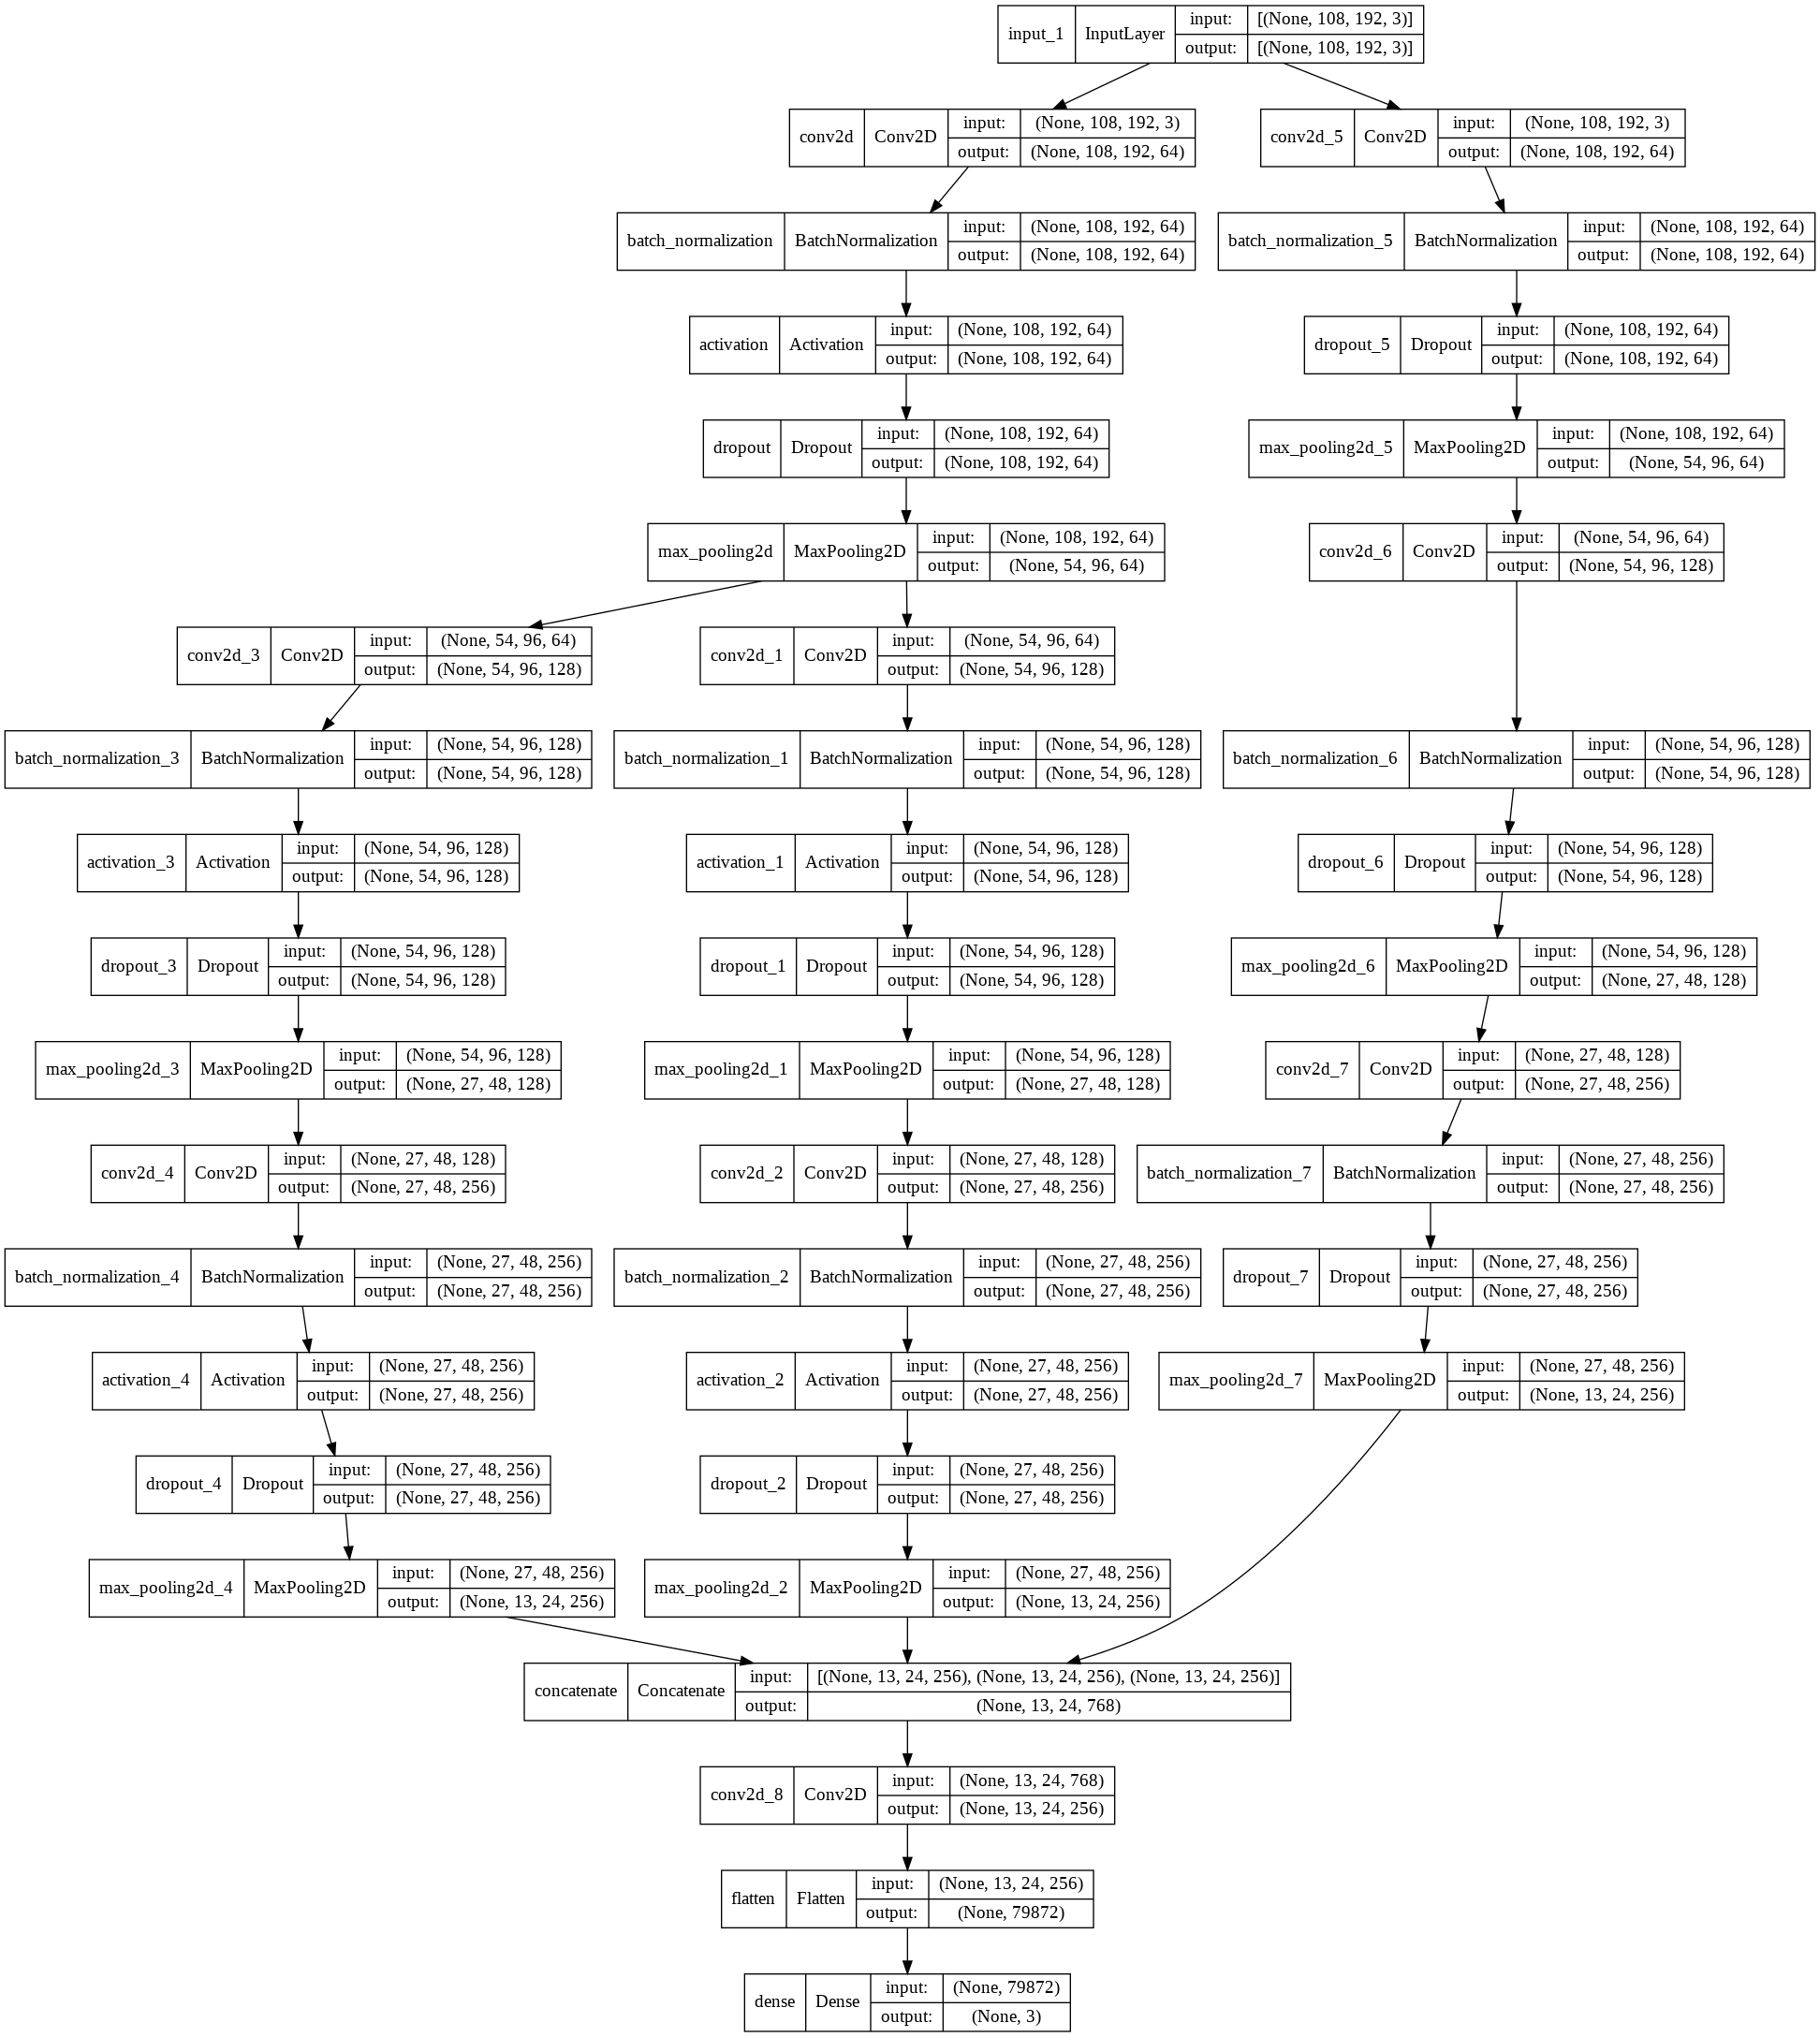

In [30]:
# Структура созданной н.с.
utils.plot_model(functional_network_model, 'func_model.png', show_shapes=True)

Epoch 1/20
300/300 [==============================] - 114s 270ms/step - loss: 32.8448 - accuracy: 0.4940 - val_loss: 5.1396 - val_accuracy: 0.4404
Epoch 2/20
300/300 [==============================] - 80s 265ms/step - loss: 5.3331 - accuracy: 0.5430 - val_loss: 7.2047 - val_accuracy: 0.4893
Epoch 3/20
300/300 [==============================] - 79s 265ms/step - loss: 3.5220 - accuracy: 0.5900 - val_loss: 4.5891 - val_accuracy: 0.4465
Epoch 4/20
300/300 [==============================] - 79s 265ms/step - loss: 2.4714 - accuracy: 0.6293 - val_loss: 3.7046 - val_accuracy: 0.5443
Epoch 5/20
300/300 [==============================] - 79s 265ms/step - loss: 2.4999 - accuracy: 0.6373 - val_loss: 4.3130 - val_accuracy: 0.5688
Epoch 6/20
300/300 [==============================] - 79s 264ms/step - loss: 1.9368 - accuracy: 0.6707 - val_loss: 2.9340 - val_accuracy: 0.5810
Epoch 7/20
300/300 [==============================] - 79s 264ms/step - loss: 1.3099 - accuracy: 0.7460 - val_loss: 3.3465 - val_

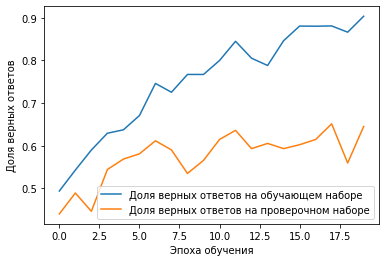

In [31]:
# Обучение сети
batch_size = 10
history = functional_network_model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=20,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Отображение графика
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/5
300/300 [==============================] - 78s 259ms/step - loss: 0.3187 - accuracy: 0.9263 - val_loss: 3.3669 - val_accuracy: 0.6391
Epoch 2/5
300/300 [==============================] - 78s 259ms/step - loss: 0.2287 - accuracy: 0.9380 - val_loss: 3.2903 - val_accuracy: 0.6177
Epoch 3/5
300/300 [==============================] - 77s 258ms/step - loss: 0.3262 - accuracy: 0.9263 - val_loss: 3.8610 - val_accuracy: 0.6514
Epoch 4/5
300/300 [==============================] - 78s 258ms/step - loss: 0.9472 - accuracy: 0.8793 - val_loss: 13.5449 - val_accuracy: 0.5138
Epoch 5/5
300/300 [==============================] - 78s 259ms/step - loss: 3.5499 - accuracy: 0.7833 - val_loss: 5.0557 - val_accuracy: 0.6024


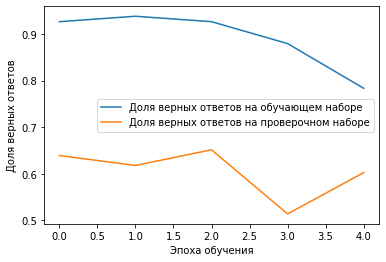

In [32]:
# Дообучение сети
batch_size = 10
history = functional_network_model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=5,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Вывод графика
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()